In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz

%matplotlib inline 

In [2]:
raw = read_raw_edf('D:\Brain_siez_det\eegfiles\eeg10.edf', preload=True, stim_channel='auto', verbose=False)
raw

C:\Users\Yash Srivastava\AppData\Local\Temp\ipykernel_18412\2051618495.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = read_raw_edf('D:\Brain_siez_det\eegfiles\eeg10.edf', preload=True, stim_channel='auto', verbose=False)
C:\Users\Yash Srivastava\AppData\Local\Temp\ipykernel_18412\2051618495.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = read_raw_edf('D:\Brain_siez_det\eegfiles\eeg10.edf', preload=True, stim_channel='auto', verbose=False)


<RawEDF | eeg10.edf, 21 x 1389312 (5427.0 s), ~222.6 MB, data loaded>

In [3]:
# what does our data look like?

print('Data type: {}\n\n{}\n'.format(type(raw), raw))
# print('{} \n'.format(raw))

# Get the sample rate
print('Sample rate:', raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(raw.get_data().shape))

Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF | eeg10.edf, 21 x 1389312 (5427.0 s), ~222.6 MB, data loaded>

Sample rate: 256.0 Hz
Size of the matrix: (21, 1389312)



Using matplotlib as 2D backend.


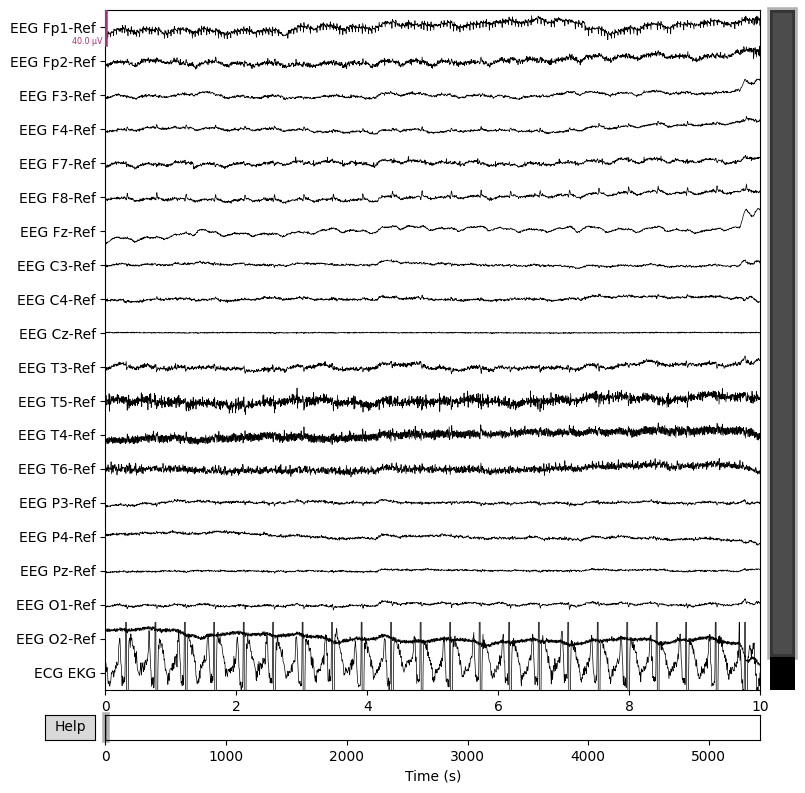

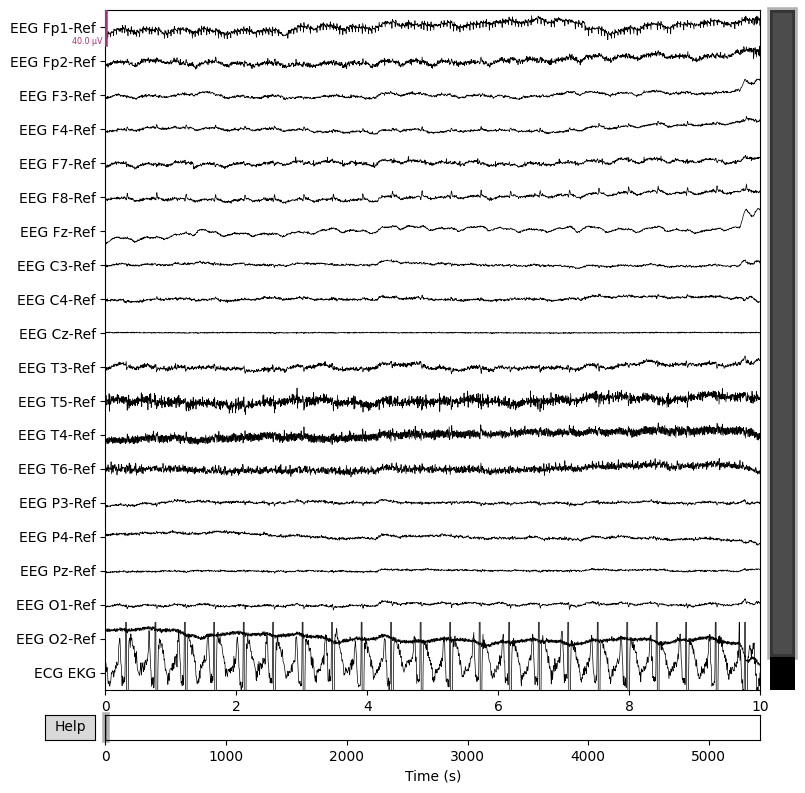

In [4]:
raw.plot()

In [5]:
print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))

The actual data is just a matrix array!

 [[-8.52886795e-06 -1.89021584e-05 -1.77309804e-05 ...  4.00000000e-09
   4.00000000e-09  4.00000000e-09]
 [-5.68457863e-06 -1.00346682e-05 -1.07039127e-05 ...  4.00000000e-09
   4.00000000e-09  4.00000000e-09]
 [-1.16717795e-06 -3.67684500e-06 -2.33835591e-06 ...  4.00000000e-09
   4.00000000e-09  4.00000000e-09]
 ...
 [ 3.18291159e-06  5.69257863e-06  3.51753386e-06 ...  4.00000000e-09
   4.00000000e-09  4.00000000e-09]
 [ 4.01946727e-06  1.15484684e-05  1.03772904e-05 ... -1.16717795e-06
   1.71311136e-07  1.67711136e-06]
 [ 1.13811573e-05  1.60658691e-05  2.05832698e-05 ... -9.19811249e-06
   2.71084041e-05  6.45860986e-05]]



In [36]:
# ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800)
# ica.fit(raw)
# ica.exclude = [1, 2]  # details on how we picked these are omitted here
# ica.plot_properties(raw, picks=ica.exclude)

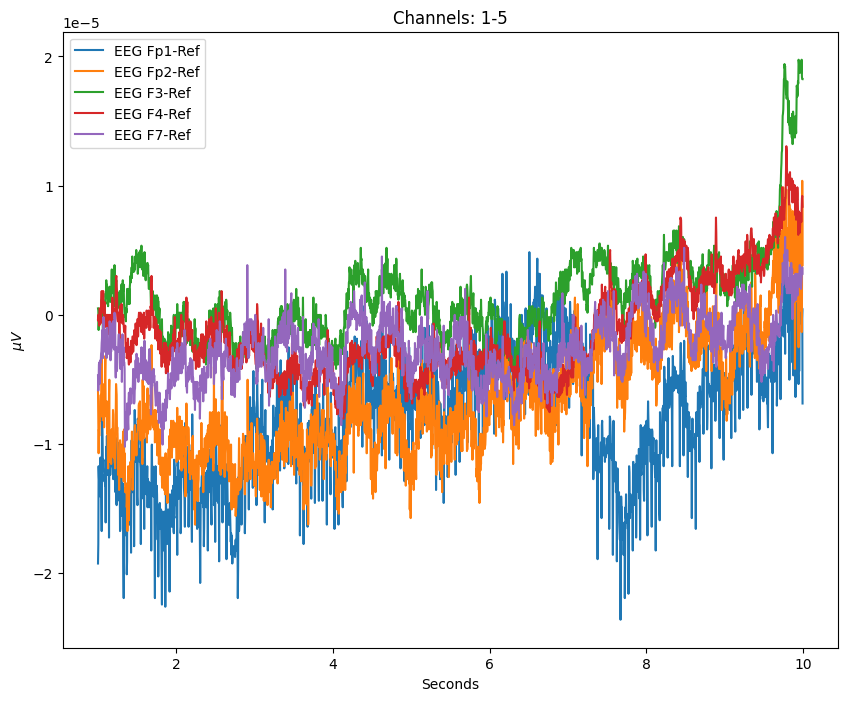

In [6]:
# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T);
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(raw.ch_names[:5])

In [7]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)


- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


<RawEDF | eeg10.edf, 21 x 1389312 (5427.0 s), ~222.6 MB, data loaded>

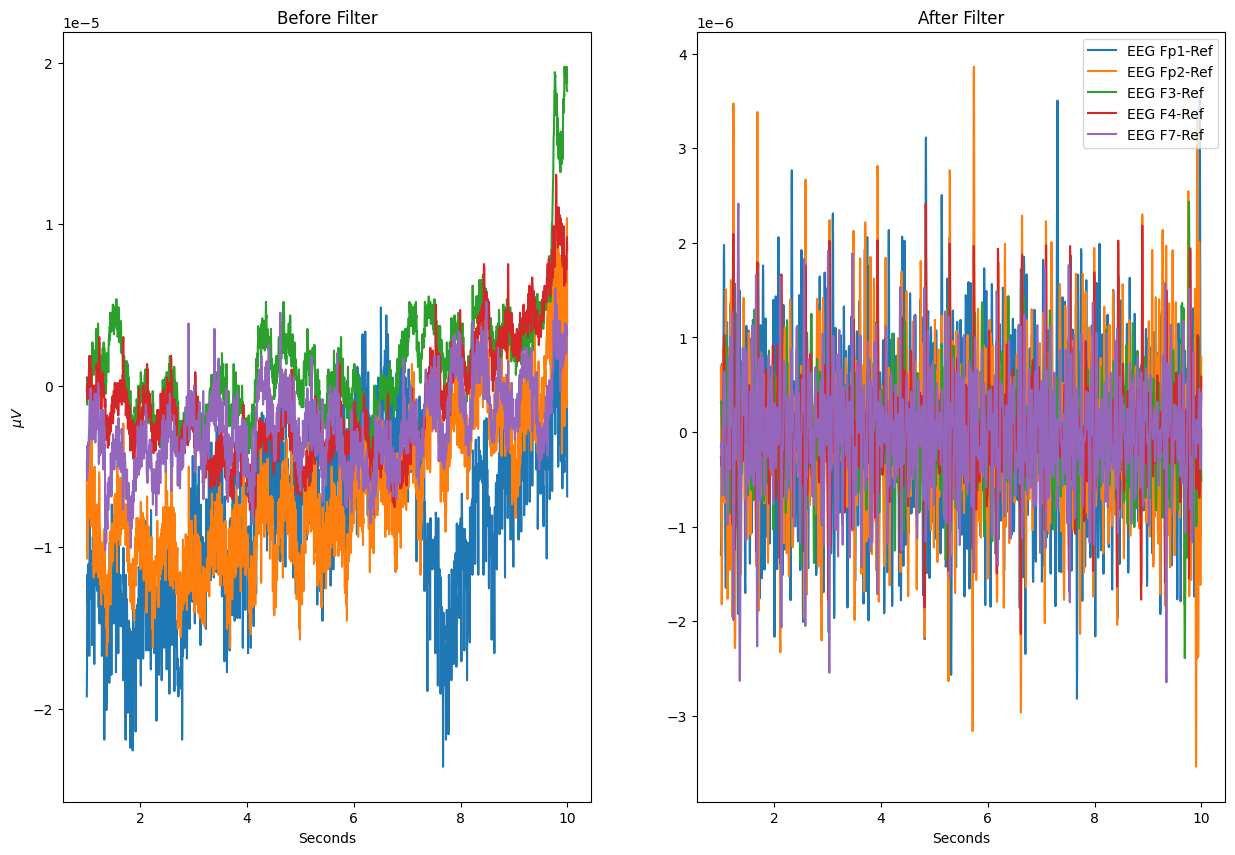

In [8]:
data_f, times_f = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))

ax1.plot(times, data.T);
ax1.set_title('Before Filter')
ax1.set_xlabel('Seconds')
ax1.set_ylabel('$\mu V$')

ax2.plot(times_f, data_f.T);
ax2.set_title('After Filter')
ax2.set_xlabel('Seconds')

plt.legend(raw.ch_names[:5], loc=1);
# plt.tight_layout()

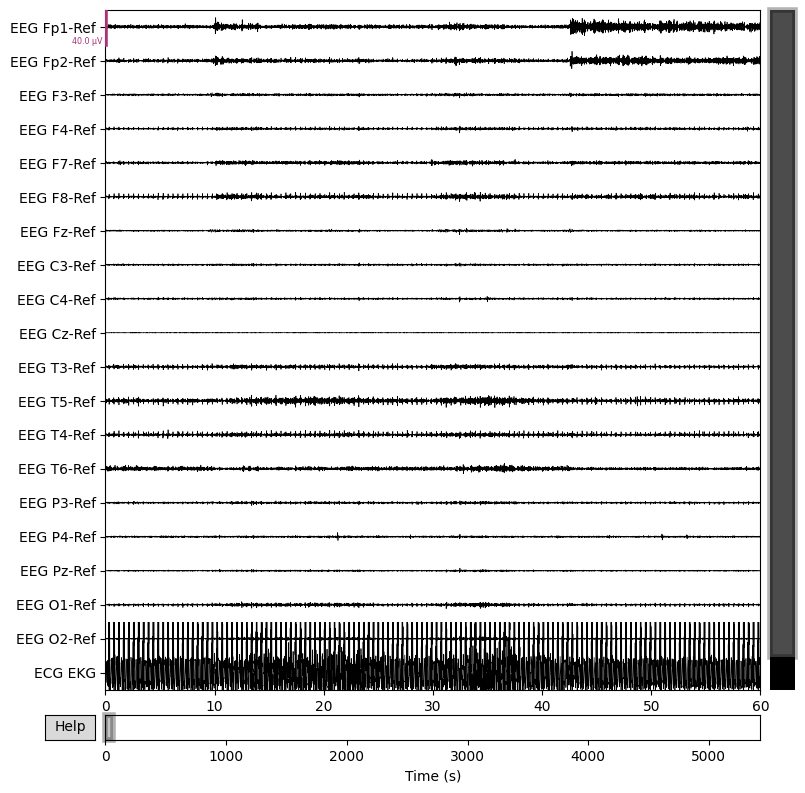

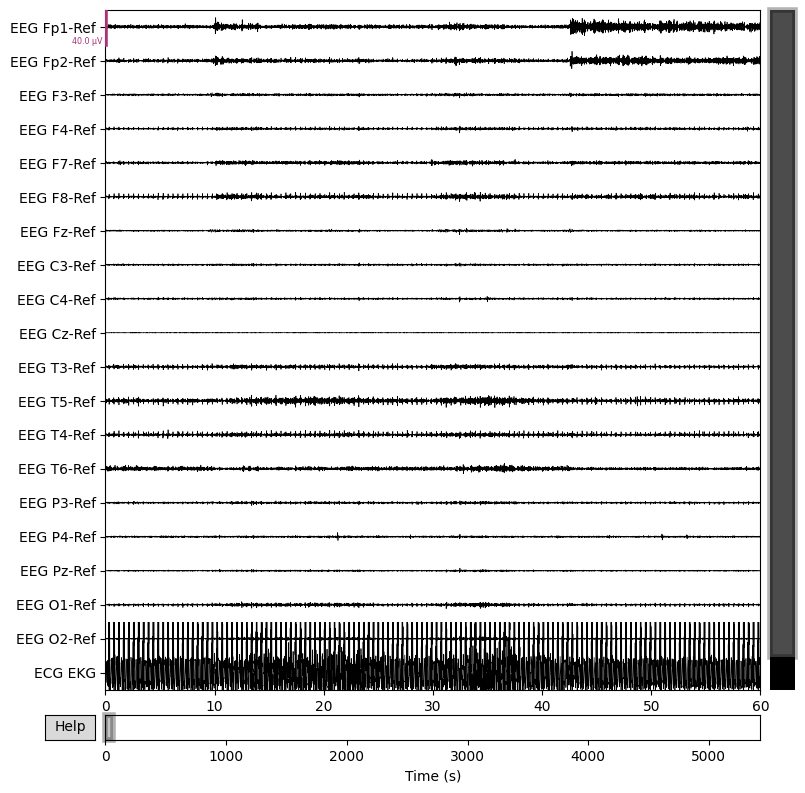

In [9]:
# %matplotlib qt
raw.plot(duration=60, block=True)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


C:\Users\Yash Srivastava\AppData\Local\Temp\ipykernel_18412\2478229336.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=128)  # Use 128 instead of 250
c:\Users\Yash Srivastava\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


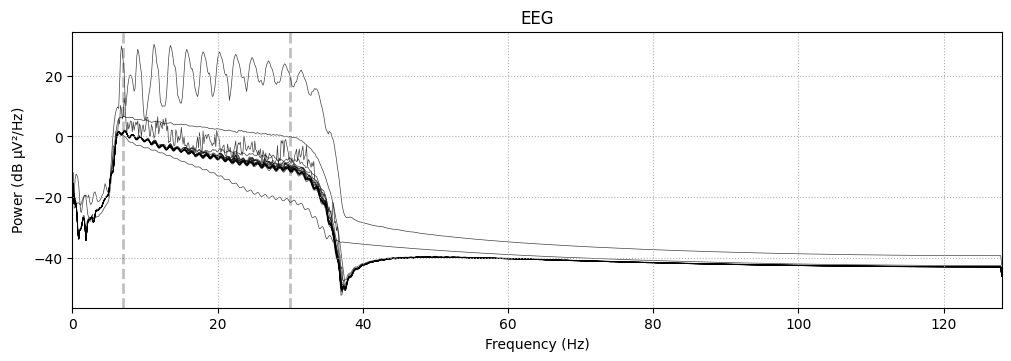

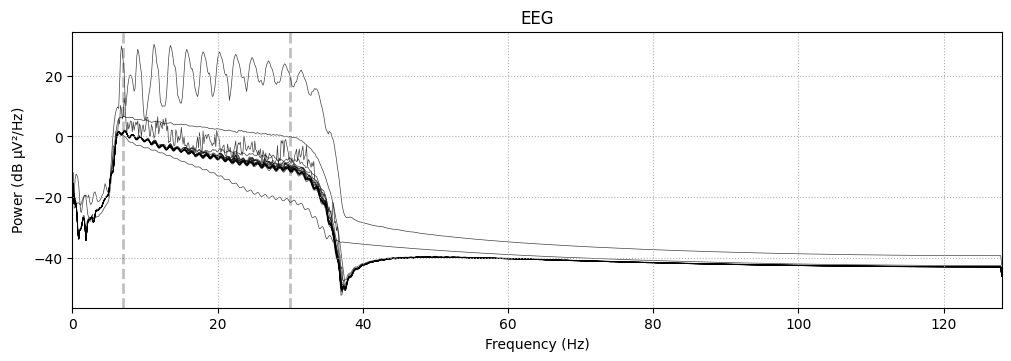

In [12]:
raw.plot_psd(tmax=np.inf, fmax=128)  # Use 128 instead of 250


In [13]:
raw_df = raw.to_data_frame()
raw_df.head()

,time,EEG Fp1-Ref,EEG Fp2-Ref,EEG F3-Ref,EEG F4-Ref,EEG F7-Ref,EEG F8-Ref,EEG Fz-Ref,EEG C3-Ref,EEG C4-Ref,...,EEG T5-Ref,EEG T4-Ref,EEG T6-Ref,EEG P3-Ref,EEG P4-Ref,EEG Pz-Ref,EEG O1-Ref,EEG O2-Ref,ECG EKG,Resp Effort
0,0.000000,-1.852885e-16,-4.235165e-16,-9.793818e-16,-1.058791e-16,-3.705769e-16,-4.235165e-16,-7.543887e-16,-2.646978e-17,-1.058791e-16,...,-1.270549e-15,-8.470329e-16,3.970467e-16,-6.352747e-16,4.235165e-16,-2.646978e-16,-4.764560e-16,8.470329e-16,0.000000,6.346130e-15
1,0.003906,-3.576286e+00,-2.239225e+00,-6.406588e-01,-1.181933e+00,-1.661907e+00,-1.425307e+00,-1.972030e+00,7.948394e-03,-1.305807e-01,...,1.976480e+00,-1.326910e+00,-1.625422e+00,-2.394817e-01,6.001104e-01,7.746496e-03,1.492466e-01,1.279110e-01,0.845243,2.997113e+00
2,0.007812,-6.287686e+00,-3.866624e+00,-1.088527e+00,-2.042460e+00,-2.849699e+00,-2.468875e+00,-3.427962e+00,-3.042047e-02,-1.932867e-01,...,3.259740e+00,-2.388702e+00,-2.873590e+00,-4.373682e-01,9.969151e-01,-1.239143e-03,2.755995e-01,2.536193e-01,1.789794,5.760376e+00
3,0.011719,-7.615240e+00,-4.534088e+00,-1.230772e+00,-2.397414e+00,-3.280941e+00,-2.916921e+00,-4.055458e+00,-1.359542e-01,-1.626718e-01,...,3.453460e+00,-3.010303e+00,-3.490885e+00,-5.611895e-01,1.067627e+00,-3.619767e-02,3.605522e-01,3.697844e-01,2.734882,8.062733e+00
4,0.015625,-7.559874e+00,-4.288425e+00,-1.074515e+00,-2.267528e+00,-2.966661e+00,-2.799580e+00,-3.851964e+00,-2.890417e-01,-7.083930e-02,...,2.615986e+00,-3.156810e+00,-3.414905e+00,-5.944267e-01,8.158726e-01,-9.245718e-02,3.943869e-01,4.631228e-01,3.321237,9.700623e+00


In [14]:
# NO STIM CHANNELS FOUND
# raw.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6)
list_channels = raw.info['ch_names']

In [13]:
# for ch in list_channels:
#     print(ch)
#     events = mne.find_events(raw, stim_channel=ch)
#     print(events)
#     print("\n")

# THERE IS NO STIM CHANNEL